<h1> Training Pokedex <h1>

<h2> Dependency loading <h2>

In [365]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


<h2> Load Imports <h2>

In [366]:
import os 
import csv
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms


<h2> Load and prep data <h2>

<h1>Prep and Load Data<h1>

<h3> Create Image Dataset Class <h3>
    
    Notes:
     Should start from root path, go through each folder in the directory take each file and place it in the datset 

In [367]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        # root_dir is the root directory to start the search
        data_paths = []
        # Traverse directories and collect data paths
        
        for dirpath, dirnames, filenames in os.walk(root_dir):
            
            for filename in filenames:
                
                # Optionally, you can add a filter to process specific types of files
                # if filename.endswith('.csv'):
                file_path = os.path.join(dirpath, filename)
                data_paths.append(file_path)
                
            
        # Read data from each path and concatenate
        self.data = []
        for path in data_paths:
            self.data.extend(self.load_data(path))
    
    def load_data(self, path):
        # Define how to load data from a single path here
        # Return the loaded data as a list of samples
       
        data = [path]
       
        # ...
        return data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]
        image = Image.open(image_path).convert('RGBA')
        if self.transform:
            image = self.transform(image)
        
        return image
    def getAllDataSet():
        return self.data

<h2> Creating Class for reading CSV data <h2>

In [368]:
class CSVDataset(Dataset):
    def __init__(self, csv_file):
        # Read data from the CSV file
        self.data = []
        with open(csv_file, 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                # Assuming 'name' is the column for names and 'label' is the column for labels
                name = row['Name']
                label = int(row['#'])  # converting label to integer
                self.data.append(name)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]

<h2> Transform and convert to tensor <h2>

In [369]:
mean = [0.5945, 0.5769, 0.5438]
std = [0.3466, 0.3297, 0.3420]
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.tensor(std))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.tensor(std) )
])


<h2>Split Data Into Testing and Training Directories<h2>

In [370]:
root_dir = 'D:\AI-ML\Datasets\pokemonImagesTypes\images\PokemonData'
img_dir = "D:\AI-ML\Datasets\pokemonImagesTypes\images\PrepedImages"
csv_dir = "D:\AI-ML\Datasets\pokemonStats\Pokemon.csv"
# Create the dataset by searching and combining data from directories
dataset = ImageDataset(root_dir)

labels =  CSVDataset(csv_dir)

# Define the split sizes (e.g., 80% for training, 20% for testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Randomly split the dataset
train_dataset, test_dataset = random_split(dataset.data, [train_size, test_size])

# Define directories to save training and testing data
train_directory = "D:\AI-ML\Datasets\pokemonImagesTypes\images\Train_Data\Train"
test_directory = "D:\AI-ML\Datasets\pokemonImagesTypes\images\Test_Data\Test"

# Create the directories if they don't exist
# Check if the directory exists
if os.path.exists(train_directory) and os.path.isdir(train_directory):
    # Delete the directory
    shutil.rmtree(train_directory)
    os.makedirs(train_directory, exist_ok=True)
    print(f'The directory "{train_directory}" has been re-created.')
else:
    print(f'The directory "{train_directory}" does not exist.')
    os.makedirs(train_directory, exist_ok=True)
    
if os.path.exists(test_directory) and os.path.isdir(test_directory):
    # Delete the directory
    shutil.rmtree(test_directory)
    os.makedirs(test_directory, exist_ok=True)
    print(f'The directory "{test_directory}" has been re-created.')
else:
    print(f'The directory "{test_directory}" does not exist.')
    os.makedirs(test_directory, exist_ok=True)
    
    


# Function to save dataset to directory file structory :directory/label/file
def save_dataset_to_directory(dataset, directory):
    for index in range(len(dataset)):
        # Get the image and label from dataset
        image_path = dataset[index]
        file_name = os.path.basename(image_path)
        directoryLabel = file_name.split('_')[0] 
        newDirectory = directory + f'\\{directoryLabel}'
        os.makedirs(newDirectory, exist_ok=True)
        # Copy the file to the destination directory
        shutil.copy(image_path, os.path.join(newDirectory, os.path.basename(image_path)))

# Save training data to train_directory
save_dataset_to_directory(train_dataset, train_directory)

# Save testing data to test_directory
save_dataset_to_directory(test_dataset, test_directory)


The directory "D:\AI-ML\Datasets\pokemonImagesTypes\images\Train_Data\Train" has been re-created.
The directory "D:\AI-ML\Datasets\pokemonImagesTypes\images\Test_Data\Test" has been re-created.


In [371]:
# Note : ImageFolder() looks for a directory with another folder in it. So data must be in child folder. SEtting root below

# Create DataLoaders for training and testing sets
train_dataset= torchvision.datasets.ImageFolder(train_directory, transform = train_transform)
test_dataset= torchvision.datasets.ImageFolder(test_directory, transform = test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

<h2>Check Data In Loader<h2>

In [372]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize = (11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)
    print(torch.cuda.is_available())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([ 65,  36, 130, 103,  98,  33])
True


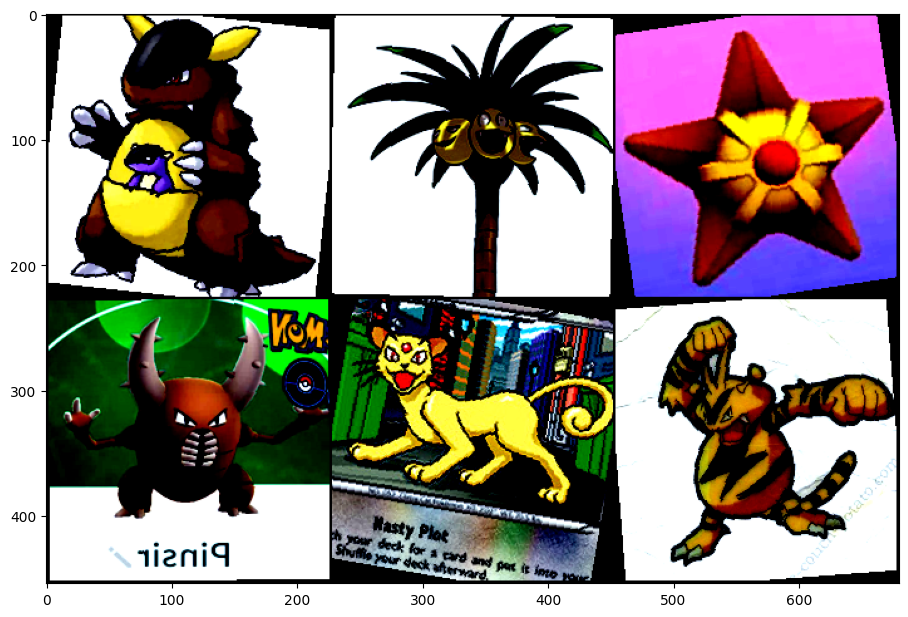

In [373]:
show_transformed_images(train_dataset)

<h2>Set Training Methods<h2>

In [374]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)
        

In [375]:
def train_nn(model, training_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    bestAcc = 0.0
    for epoch in range(n_epochs):
        print("Epoch numer %d " %(epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for data in training_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            
            # Back Propagation
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()
            
        # Stats to print
        
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total
        
        print("     Training Dataset: %d out of %d images labeled correctly ( %.3f%%). Epoch loss: %.3f" 
              % (running_correct, total, epoch_acc, epoch_loss))
        
        testDataAcc = evaluate_model_on_test_set(model, test_loader)
        
        if(testDataAcc > bestAcc):
            bestAcc = testDataAcc
            save_checkpoint(model, epoch, optimizer, bestAcc) 
    print("Finished")
    return model

In [376]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()
    # below will also turn off back propagation as you do not want to back propagate test data set
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
    
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            predicted_correctly_on_epoch += (predicted == labels).sum().item()
            
    epoch_acc = 100.00 * predicted_correctly_on_epoch / total
        
    print("     Testing Dataset: %d out of %d images labeled correctly ( %.3f%%)." 
            % (predicted_correctly_on_epoch, total, epoch_acc))
        
    return epoch_acc

<h2>Set Training Configs<h2>

In [377]:
resnet18_model = models.resnet18(pretrained = False)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 150
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.007, momentum=0.9, weight_decay=0.003)

<h2> Train Model <h2>

In [378]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 150)

Epoch numer 1 
     Training Dataset: 307 out of 5575 images labeled correctly ( 5.507%). Epoch loss: 4.550
     Testing Dataset: 113 out of 1393 images labeled correctly ( 8.112%).
Epoch numer 2 
     Training Dataset: 743 out of 5575 images labeled correctly ( 13.327%). Epoch loss: 3.578
     Testing Dataset: 235 out of 1393 images labeled correctly ( 16.870%).
Epoch numer 3 
     Training Dataset: 1174 out of 5575 images labeled correctly ( 21.058%). Epoch loss: 3.124
     Testing Dataset: 325 out of 1393 images labeled correctly ( 23.331%).
Epoch numer 4 
     Training Dataset: 1590 out of 5575 images labeled correctly ( 28.520%). Epoch loss: 2.765
     Testing Dataset: 373 out of 1393 images labeled correctly ( 26.777%).
Epoch numer 5 
     Training Dataset: 1976 out of 5575 images labeled correctly ( 35.444%). Epoch loss: 2.462
     Testing Dataset: 510 out of 1393 images labeled correctly ( 36.612%).
Epoch numer 6 
     Training Dataset: 2260 out of 5575 images labeled correctly

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2>Save Model<h2>

In [379]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        'epoch' :  epoch + 1,
        'model' : model.state_dict(),
        'best_accuracy' : best_acc,
        'optimizer' : optimizer.state_dict(),
        'modelName' : 'AI Poke-dex'
                     
    }
    torch.save(state, 'D:\AI-ML\Models\AiPokedex\\best_model_checkpoint.pth.tar')

<h2>Load Model<h2>

In [381]:
checkpoint = torch.load('D:\AI-ML\Models\AiPokedex\\best_model_checkpoint.pth.tar')

print(checkpoint['epoch'])
print(checkpoint['best_accuracy'])

131
88.2986360373295


In [383]:
resnet18_model = models.resnet18()
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 150
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
resnet18_model.load_state_dict(checkpoint['model'])

torch.save(resnet18_model, 'D:\AI-ML\Models\AiPokedex\\pokedex_best.pth') 

<h2>Load Model and Use!<h2>
    <p>This can be done in any notebook as long as you have the file path for upload<p>
    

Setting Same classes that were in trainning models. 

In [384]:
pokemon_classes = []
for item in os.listdir(root_dir):
     # Construct the full path of the item
    item_path = os.path.join(root_dir, item)
    # Check if the item is a directory
    if os.path.isdir(item_path):
        # If it is a directory, add its name to the array
        pokemon_classes.append(item)
        
print(pokemon_classes)
        

['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Ni

In [392]:
model = torch.load('D:\AI-ML\Models\AiPokedex\\pokedex_best.pth')


In [393]:
mean = [0.5945, 0.5769, 0.5438]
std = [0.3466, 0.3297, 0.3420]
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.tensor(std))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.tensor(std) )
])


In [403]:
def classify(model, test_transforms, image_path, classes):
    model = model.eval()
    image = Image.open(image_path)
    image = test_transforms(image).float()
    image = image.unsqueeze(0)
    
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    
    print(pokemon_classes[predicted.item()])
    im = Image.open(image_path)
    display(im)
    

<h2>Replace The Path below with the path to a JPEG picture of a pokemon(first 150 / oldschool) and the label should appear below</h2>

Kadabra


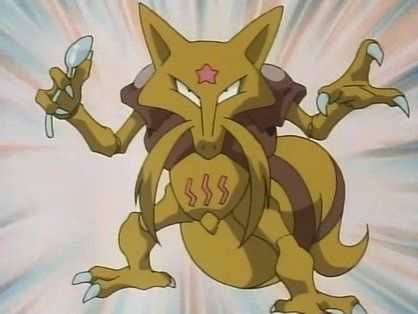

In [413]:
classify(model, test_transform,r"D:\AI-ML\Datasets\pokemonImagesTypes\images\Application\c8be5c17031bb847657c27dc5ae98558-1200-80.jpg", pokemon_classes)

<h2>Util Functions Below<h2>

Note below function gets mean and std which will be needed later 

# Initialize the sum and the number of images
channel_sum = torch.zeros(3)
channel_squared_sum = torch.zeros(3)
num_pixels = 0

# Sum the pixel values in each channel
for data, _ in train_loader:
    image = data[0]  # Shape is (3, H, W)
    channel_sum += image.view(3, -1).sum(dim=1)
    channel_squared_sum += (image.view(3, -1) ** 2).sum(dim=1)
    num_pixels += image.view(3, -1).size(1)

# Calculate the mean
mean = channel_sum / num_pixels

# Calculate the standard deviation
std = torch.sqrt((channel_squared_sum / num_pixels) - (mean ** 2))

# Output the mean and standard deviation
print(f'Mean: {mean}')
print(f'Standard Deviation: {std}')

<h2>Define Labels<h2>

In [380]:
def GetLabel(fileName:str):
    return fileName.split('_')[0]
GetLabel("Vaporeon_0.jpeg") #Testing

'Vaporeon'